# Importing required Libraries

In [0]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

# Fetching Datasets

In [0]:
mnist = fetch_openml('mnist_784')

In [0]:
iris = datasets.load_iris()

# Question 2 a

Varience contained by each component

In [0]:
# Separating out the features
x = iris.data[:, :4]

# Separating out the target
y = iris.target

# Standardizing the features
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
print(pca.explained_variance_ratio_)

[0.72962445 0.22850762 0.03668922 0.00517871]


In [0]:
def plotPCA(principalComponent):
    principalDf = pd.DataFrame(data=principalComponent,
                               columns=['principal component 1', 'principal component 2'])
    df = pd.DataFrame(data = y, columns=['target'])
    finalDf = pd.concat([principalDf, df], axis=1)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Principal Component 1', fontsize=15)
    ax.set_ylabel('Principal Component 2', fontsize=15)
    ax.set_title('2 component PCA', fontsize=20)
    targets = [0, 1, 2]
    colors = ['r', 'g', 'b']
    for target, color in zip(targets, colors):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c=color
                   , s=50)
    ax.grid()
    plt.show()

First 2 Components

Last 2 components

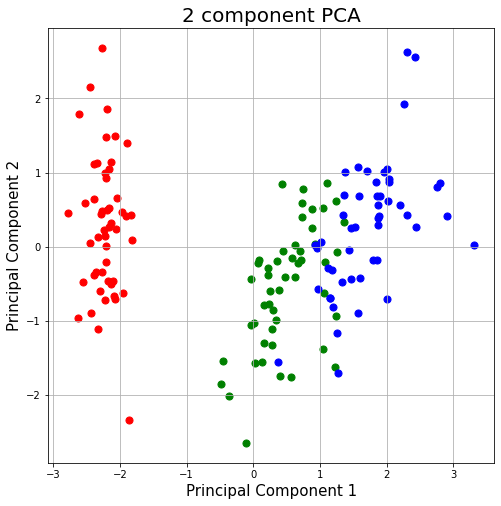

In [0]:
plotPCA(principalComponents[0:, 0:2])

Here we can see that majority of the information is retained by the first 2 components and we can see the three points gets clustered in such a way that they are easily seperable into respective classes.

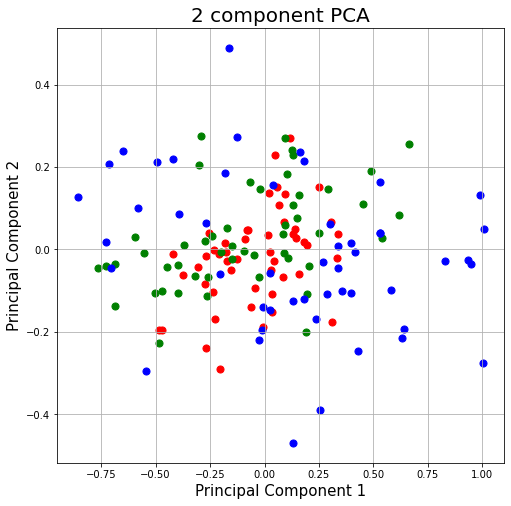

In [0]:
plotPCA(principalComponents[0:, 2:4])

Last 2 components contain minimal amount of data and the plot of the 2 components appears to be just a bunch of random points on the graph and no visible information can be obtained.

# Question 2 b

Scaling the data

In [0]:
train_data = mnist.data[:60000, :]
test_data = mnist.data[60000:, :]
train_label = mnist.target[:60000]
test_label = mnist.target[60000:]

scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

varience = [0.50, 0.75, 0.90, 0.95]

Simple feed forward network

In [0]:
def train(input_size, epochs, train_data, train_label):
    losses=[]
    train_data = train_data
    train_lable = train_label
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(input_size, 84)       
            self.fc3 = nn.Linear(84, 10)        

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.log_softmax(self.fc3(x), dim=0)

            return x

    print("Initializing the network ...")
    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(net.parameters(), lr=0.001) # lr = learning rate/step size

    ##### Training the network ###################################################
    print("Training the network ...")
    for e in range(epochs):  # loop over the dataset multiple times
        #print("Epoch: ", e+1)
        
        inputs, labels = train_data,train_label

        optimizer.zero_grad() # zero the parameter gradients

        outputs = net(inputs) # forward pass
        loss = criterion(outputs, labels) # compute loss
        loss.backward() # backward pass
        optimizer.step() # gradient descent update
        losses.append(loss.item())

    print("Evaluating on training data ...")
    correct = 0
    total = 0
    with torch.no_grad():
        inputs, labels = train_data,train_lable
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_acc = correct / total
    return losses, train_acc, net

    ##### Evaluating the network on test data ####################################
def test(test_data,test_label,net):
    print("Evaluating on test data ...")
    correct = 0
    total = 0
    with torch.no_grad():
        inputs, labels = test_data,test_label
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_acc = correct / total
        
    return test_acc

Generate various PCA instances as per varience level

In [0]:
def generatePCA(train_data, train_label, test_data, test_label):   
    pcaList = []
    train_label=np.array(train_label,dtype="long")
    train_label=torch.from_numpy(train_label)
        
    test_label=np.array(test_label,dtype="long")
    test_label=torch.from_numpy(test_label)
    
    for var in varience:
        pca = PCA(var)
        pca.fit(train_data)
        train_data_ = pca.transform(train_data)
        test_data_ = pca.transform(test_data)

        train_data_=np.array(train_data_,dtype="float32")
        train_data_=torch.from_numpy(train_data_)
        test_data_=np.array(test_data_,dtype="float32")
        test_data_=torch.from_numpy(test_data_)

        print(str(pca.n_components_) + " components")
        variables = {"pca":pca, "train_data":train_data_, "test_data":test_data_, "percent":var}
        pcaList.append(variables)
    return pcaList


Here I observed that to retain 50% of the information only 39 components of 784 components are enough. 75% of the information is retained by 120 components. To retain 95% of the information 331 components are required. Law of diminishing returns is best followed here. 39 components retain the first 50% of the information and to gain next 45% we need to add 292 more components. The last 453 components contain only 5% of information in total.

In [53]:
pcaList = generatePCA(train_data, train_label, test_data, test_label)

39 components
120 components
236 components
331 components


In [0]:
def showPCA(pcaList, train_label, test_label):
    pcaList = pcaList
    train_label=np.array(train_label,dtype="long")
    train_label=torch.from_numpy(train_label)
        
    test_label=np.array(test_label,dtype="long")
    test_label=torch.from_numpy(test_label)
    
    for variables in pcaList:
        pca = variables["pca"]
        train_data = variables["train_data"]
        test_data = variables["test_data"]
        
        # Passing the data obtained from PCA into train() function
        # Train function is the simple feed forward network.
        losses, train_acc, obj = train(pca.n_components_,200, train_data, train_label)
        test_acc = test(test_data,test_label,obj)
        print("Training accuracy: ", train_acc)
        print("Test accuracy: ", test_acc)
        plt.plot(losses)
        plt.show()

We are compressing the training data into fewer components to retain a certain level of information and then training the network on the compressed data. The size on input changes from 60000X764 to 60000X39 while retaining 50% of the information. The size of compressed data is 4.97% of the original data but it retains 50% of the informaion of the original data. The quality of the model is tested by compressing the test data using the same compression scheme(PCA) and predicting the class of the image. It can be seen that with even 50% of the original information, the model is able to maintain the accuracy of 95% on training dataset and 94.7% on testing dataset.

Initializing the network ...
Training the network ...
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9505666666666667
Test accuracy:  0.9478


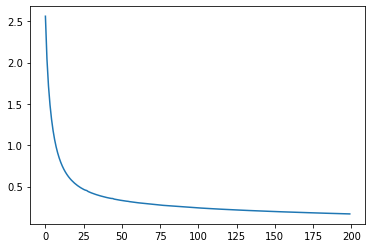

Initializing the network ...
Training the network ...
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9472166666666667
Test accuracy:  0.9334


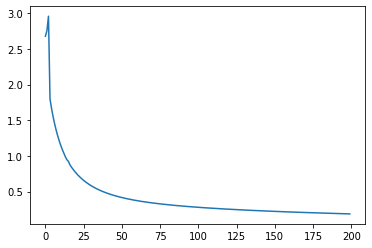

Initializing the network ...
Training the network ...
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.94525
Test accuracy:  0.9415


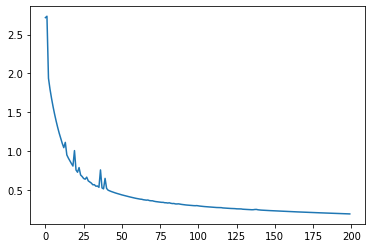

Initializing the network ...
Training the network ...
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9665666666666667
Test accuracy:  0.9513


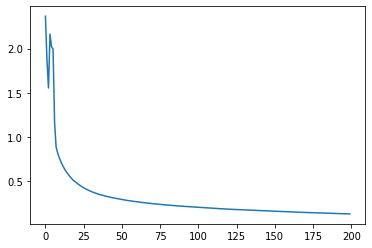

In [28]:
showPCA(pcaList, train_label, test_label)

Reconstruct data from PCA

Data is generated from compressed form to original 784 components using inverse transform function of the PCA. We can compare the original image to the regenerated imageand visually observe that we could make out the numbers in the regenerated image.

In [0]:
def regenerationPCA(pcaList):
    ApproximationList = []
    for variables in pcaList:
        pca_ = variables["pca"]
        train_data_ = variables["train_data"]
        test_data_ = variables["test_data"]
        var = variables["percent"]
        approximation = pca_.inverse_transform(train_data_)
        
        approximationTest = pca_.inverse_transform(test_data_)
        plt.figure(figsize=(12,6));

        # Original Image
        plt.subplot(1, 4, 1);
        plt.imshow(mnist.data[1].reshape(28,28), interpolation='none',
                    clim=(0, 255));
        plt.xlabel('784 components', fontsize = 14)
        plt.title('Original Image', fontsize = 20);

        # 154 principal components
        plt.subplot(1, 4, 2);
        plt.imshow(approximation[1].reshape(28, 28), interpolation='none',
                );
        plt.xlabel((str(pca_.n_components_)+' components'), fontsize = 14)
        plt.title((str(var)+' Variance'), fontsize = 20);

        # Original Image Test
        plt.subplot(1, 4, 3);
        plt.imshow(mnist.data[60000].reshape(28,28), interpolation='none', clim=(0, 255));
        plt.xlabel('784 components', fontsize = 14)
        plt.title('Original Test Image', fontsize = 20);

        # 154 principal components
        plt.subplot(1, 4, 4);
        plt.imshow(approximationTest[0].reshape(28, 28), interpolation='none',
                );
        plt.xlabel((str(pca_.n_components_)+' components'), fontsize = 14)
        plt.title((str(var)+' Variance'), fontsize = 20);
        plt.show()
        ApproximationList.append((approximation,approximationTest))
    return ApproximationList

Displaying the reconstructed data

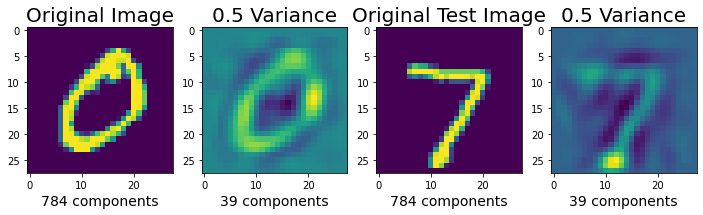

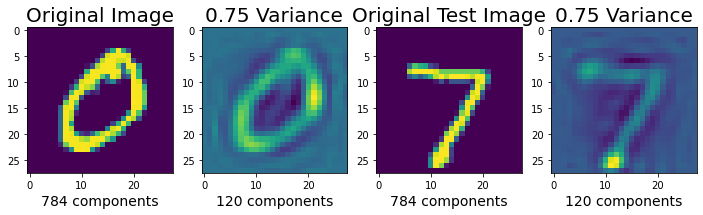

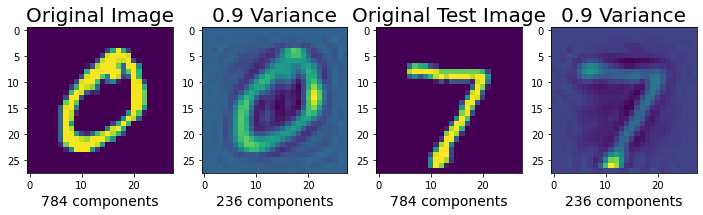

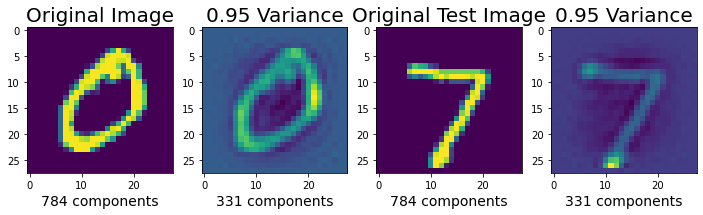

In [29]:
ApproximationList = regenerationPCA(pcaList)

The original images were first scaled before getting compressed and on decompression we get back the scaled version of the original image.

Training the CNN on the reconstructed data

CNN of Question 1

In [0]:
def eval_net(epochs, batch_size, train_data, train_label, test_data, test_label):
    train_data_ = list(zip(train_data, train_label))
    test_data_ = list(zip(test_data, test_label))
    ##### Prepare return values ##################################################
    losses = []
    train_acc = 0
    test_acc = 0

    ##### Create iterators for each dataset ######################################
    train_loader = torch.utils.data.DataLoader(train_data_, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data_, batch_size=batch_size, shuffle=False)

##### Define the network #####################################################
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(1, 6, 3)     # 1 channel in, 6 filters out, 3x3 filters
            self.pool = nn.MaxPool2d(2, 2)      # 2x2 pooling, with a stride of 2 (move the window by 2 pixels)
            self.conv2 = nn.Conv2d(6, 16, 3)    # 6 filters in, 16 filters out, 3x3 filters
            self.fc1 = nn.Linear(16 * 5 * 5, 120) # the 16 filtered images are reduced to 5x5 now, connect to 120 hidden units out
            self.fc2 = nn.Linear(120, 84)       # 120 hidden units in, 84 hidden units out
            self.fc3 = nn.Linear(84, 10)        # 84 hidden units in, 10 outputs units

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5) # .view() is similar to .reshape(), so this flattens x into a vector
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.log_softmax(self.fc3(x), dim=1)
            return x

##### Initialize the network and optimizer ###################################
    print("Initializing the network ...")
    net = Net()
    net.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(net.parameters(), lr=0.001) # lr = learning rate/step size

    ##### Training the network ###################################################
    print("Training the network ...")
    for e in range(epochs):  # loop over the dataset multiple times
        print("Epoch: ", e+1)
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad() # zero the parameter gradients

            outputs = net(inputs) # forward pass
            loss = criterion(outputs, labels) # compute loss
            loss.backward() # backward pass  retain_graph = True
            optimizer.step() # gradient descent update
            losses.append(loss.item())

    ##### Evaluating the network on training data ################################
    print("Evaluating on training data ...")
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            inputs, labels = data
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = correct / total

    ##### Evaluating the network on test data ####################################
    print("Evaluating on test data ...")
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc = correct / total

    return losses, train_acc, test_acc

Training the Model

In [0]:
def trainCNN(train_label, test_data, test_label, ApproximationList):
    test_data=np.array(test_data,dtype="float32")
    test_data=torch.from_numpy(test_data).cuda()

    train_label=np.array(train_label,dtype="long")
    train_label=torch.from_numpy(train_label).cuda()
    
    test_label=np.array(test_label,dtype="long")
    test_label=torch.from_numpy(test_label).cuda()

    


    for data in ApproximationList:
        train_data_,test_data0 = data


        train_data_=np.array(train_data_,dtype="float32")
        train_data_=torch.from_numpy(train_data_).cuda()


        train_data_=torch.reshape(train_data_,(train_data_.shape[0],1,28,28))
        test_data=torch.reshape(test_data,(test_data.shape[0],1,28,28))

        c = train_data_[0].detach().cpu().numpy()
        plt.subplot(1, 2, 1);
        plt.imshow(c[0].reshape(28, 28), interpolation='none');
        plt.title(('Training Image Sample'), fontsize = 15);

        c = test_data[0].detach().cpu().numpy()
        plt.subplot(1, 2, 2);
        plt.imshow(c[0].reshape(28, 28), interpolation='none');
        plt.title(('Testing Image Sample'), fontsize = 15);
        plt.show()

        losses, train_acc, test_acc = eval_net(5, 100, train_data_, train_label, test_data, test_label)

        print("Training accuracy: ", train_acc)
        print("Test accuracy: ", test_acc)
        plt.plot(losses)
        plt.show()
        

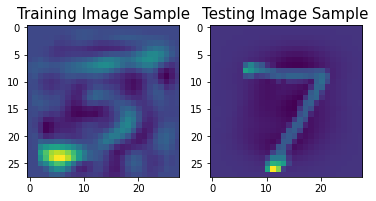

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.97735
Test accuracy:  0.9643


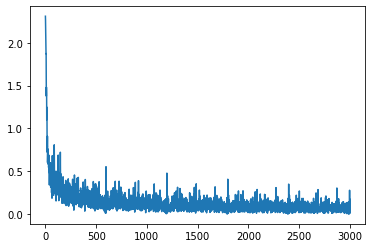

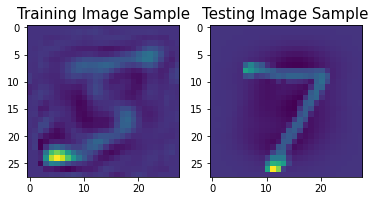

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.98535
Test accuracy:  0.9779


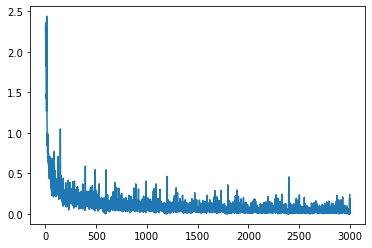

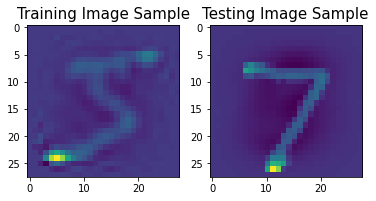

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9909333333333333
Test accuracy:  0.9826


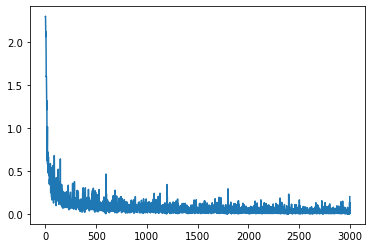

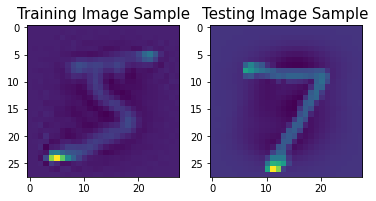

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9885333333333334
Test accuracy:  0.984


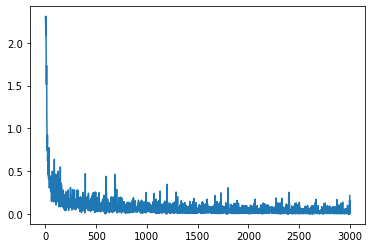

In [49]:
trainCNN(train_label, test_data, test_label, ApproximationList)

Here we could observe that our simple model could accept a mangled reconstruction of digits from 39 components and was able to accurately predict the class of test data 96% of the time. Increasing the quality of the traning image gradually increased the accuracy of the model and with 331 component training image we were able to achieve 98.4% accuracy on training dataset.

# Question 2 c

Defining a very simple autoencoder
It is a very simple auto encoder with input as 784 and 500 as output. 500 is then further compressed to bottle neck layer. To encode the data, the bottle neck layer is first decompressed to a hidden layer of 500 neurons and then to 784 to recover decoded data.

In [0]:
# Very simple autoencoder
def auto(bottleNeck, train_data, test_data):
    bottleNeck = bottleNeck

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=False)
   

    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.encoder = nn.Linear(784, 500)
            self.hidden1 = nn.Linear(500,bottleNeck)
            self.hidden2 = nn.Linear(bottleNeck,500)
            self.decoder = nn.Linear(500, 784)

        def forward(self, x):
            x = F.relu(self.encoder(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
            x = torch.sigmoid(self.decoder(x))
            return x
        
        def encode(self, x):
            x = F.relu(self.encoder(x))
            x = F.relu(self.hidden1(x))
            return x
        def decode(self,x):
            x = F.relu(self.hidden2(x))
            x = torch.sigmoid(self.decoder(x))
            return x
    net = Net()
    criterion = nn.MSELoss()
    optimizer = optim.RMSprop(net.parameters(), lr=0.001) 

    # Train the network
    for e in range(5):
        for data in train_loader:
            optimizer.zero_grad() 

            out = net(data)
            loss = criterion(out, data) # Note that train_x is being used as labels
            loss.backward()
            optimizer.step()
            

    encoded_test = net.encode(test_data)
    decoded_test = net.decode(encoded_test)
    encoded_train = net.encode(train_data)
    decoded_train = net.decode(encoded_train)
    return encoded_train, encoded_test, decoded_train, decoded_test

Enabling CUDA
cuda is enabled to speedup the model training

In [0]:
torch.cuda.device('cuda')

Training the autoencoder
Model is trained with similar number of bottleneck neurons as the number of components in PCA with set varience. Data is first encoded and then decoded.

In [0]:
def trainAuto(train_data, train_label, test_data, test_label):

    train_data=np.array(train_data,dtype="float32")
    train_data=torch.from_numpy(train_data)

    test_data=np.array(test_data,dtype="float32")
    test_data=torch.from_numpy(test_data)

    train_label=np.array(train_label,dtype="long")
    train_label=torch.from_numpy(train_label)
        
    test_label=np.array(test_label,dtype="long")
    test_label=torch.from_numpy(test_label)


    bottleNeck = [39,120,236,331]
    for btn in bottleNeck:
        encoded_train, encoded_test, decoded_train, decoded_test=auto(btn, train_data, test_data)

        loss, train_ac, net = train(btn, 1000, encoded_train.detach(), train_label)
        test_ac = test(encoded_test.detach(), test_label, net)
        print("Training accuracy: ", train_ac," Feed Forward Network")
        print("Test accuracy: ", test_ac," Feed Forward Network")
        plt.plot(loss)
        plt.show()

        scaler = StandardScaler()
        scaler.fit(decoded_train.detach().numpy())
        decoded_train = scaler.transform(decoded_train.detach().numpy())
        decoded_test = scaler.transform(decoded_test.detach().numpy())

        decoded_train=torch.from_numpy(decoded_train)
        decoded_test=torch.from_numpy(decoded_test)

        decoded_train = torch.reshape(decoded_train,(decoded_train.shape[0],1,28,28))
        decoded_test = torch.reshape(decoded_test,(decoded_test.shape[0],1,28,28))


        losses, train_acc, test_acc = eval_net(5, 100, decoded_train.cuda(), train_label.cuda(), decoded_test.cuda(), test_label.cuda())

        print("Training accuracy: ", train_acc)
        print("Test accuracy: ", test_acc)
        plt.plot(losses)
        plt.show()
        c = decoded_test.detach().numpy()
        plt.subplot(1, 2, 2);
        plt.imshow(c[0].reshape(28, 28), interpolation='none');
        plt.title(('Decoded'), fontsize = 20);
        plt.show()

Result consists of 3 parts.
for each of 4 different varience level all of the below steps occur.
First part shows the accuracy of the with simple feed forward network.
Then the same data is passed through the CNN and results are shown.
Sample of the decoded image is displayed.
All of the following results are for NON_LINEAR auto encoder

Initializing the network ...
Training the network ...
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9810833333333333  Feed Forward Network
Test accuracy:  0.9684  Feed Forward Network


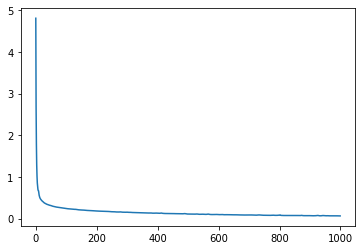

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9794666666666667
Test accuracy:  0.9693


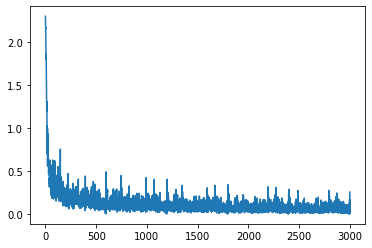

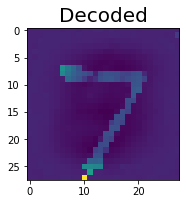

Initializing the network ...
Training the network ...
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.99235  Feed Forward Network
Test accuracy:  0.9744  Feed Forward Network


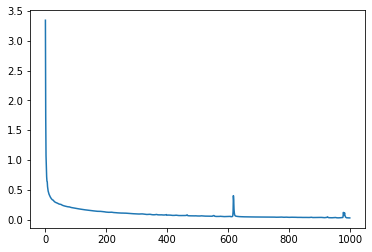

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.978
Test accuracy:  0.9693


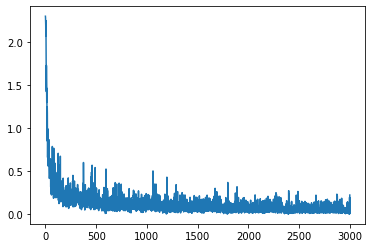

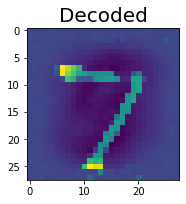

Initializing the network ...
Training the network ...
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9952333333333333  Feed Forward Network
Test accuracy:  0.9748  Feed Forward Network


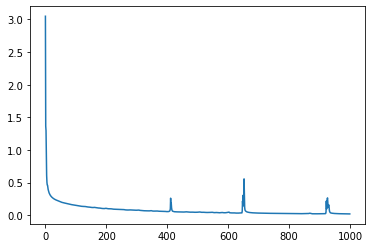

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9801
Test accuracy:  0.9688


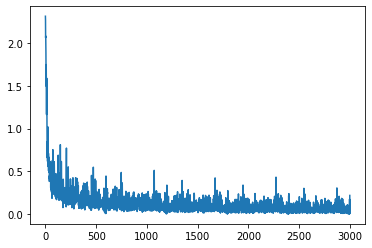

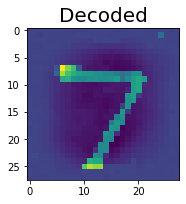

Initializing the network ...
Training the network ...
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.99515  Feed Forward Network
Test accuracy:  0.976  Feed Forward Network


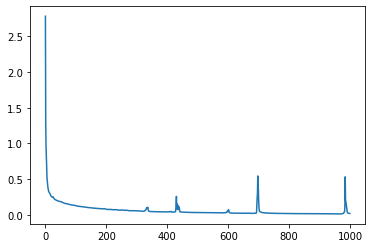

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9814666666666667
Test accuracy:  0.9718


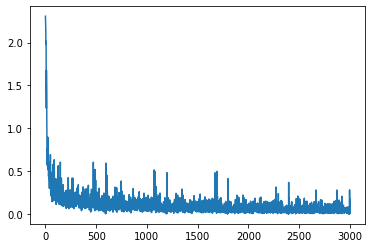

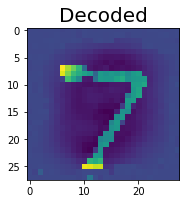

In [72]:
trainAuto(train_data, train_label, test_data, test_label)

On comparing the performance of autoencoder with PCA I observed that auto encoder was performing similar to PCA, but output of PCA was able to converge faster on feed forward network but regenerated image of autoencoder were of much sharper and similar compared to the original image. It seemed to me that neural net in auto encoder was learning something similar to PCA on its own without any previous knowledge of the problem statement.

# Question 2 d

Linear auto Encoder

In [0]:
def linearAuto(bottleNeck, train_data, test_data):
    bottleNeck = bottleNeck

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=False)
   

    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.encoder = nn.Linear(784, 500)
            self.hidden1 = nn.Linear(500,bottleNeck)
            self.hidden2 = nn.Linear(bottleNeck,500)
            self.decoder = nn.Linear(500, 784)

        def forward(self, x):
            x = self.encoder(x)
            x = self.hidden1(x)
            x = self.hidden2(x)
            x = torch.sigmoid(self.decoder(x))
            return x
        
        def encode(self, x):
            x = self.encoder(x)
            x = self.hidden1(x)
            return x
        def decode(self,x):
            x = self.hidden2(x)
            x = torch.sigmoid(self.decoder(x))
            return x
    net = Net()
    criterion = nn.MSELoss()
    optimizer = optim.RMSprop(net.parameters(), lr=0.001) 

    # Train the network
    for e in range(5):
        for data in train_loader:
            optimizer.zero_grad() 

            out = net(data)
            loss = criterion(out, data) # Note that train_x is being used as labels
            loss.backward()
            optimizer.step()
            

    encoded_test = net.encode(test_data)
    decoded_test = net.decode(encoded_test)
    encoded_train = net.encode(train_data)
    decoded_train = net.decode(encoded_train)
    return encoded_train, encoded_test, decoded_train, decoded_test

Train the Linear autoencoder

In [0]:
def trainLinearAuto(train_data, train_label, test_data, test_label):

    train_data=np.array(train_data,dtype="float32")
    train_data=torch.from_numpy(train_data)

    test_data=np.array(test_data,dtype="float32")
    test_data=torch.from_numpy(test_data)

    train_label=np.array(train_label,dtype="long")
    train_label=torch.from_numpy(train_label)
        
    test_label=np.array(test_label,dtype="long")
    test_label=torch.from_numpy(test_label)


    bottleNeck = [39,120,236,331]
    for btn in bottleNeck:
        encoded_train, encoded_test, decoded_train, decoded_test=linearAuto(btn, train_data, test_data)

        loss, train_ac, net = train(btn, 1000, encoded_train.detach(), train_label)
        test_ac = test(encoded_test.detach(), test_label, net)
        print("Training accuracy: ", train_ac," Feed Forward Network")
        print("Test accuracy: ", test_ac," Feed Forward Network")
        plt.plot(loss)
        plt.show()

        scaler = StandardScaler()
        scaler.fit(decoded_train.detach().numpy())
        decoded_train = scaler.transform(decoded_train.detach().numpy())
        decoded_test = scaler.transform(decoded_test.detach().numpy())

        decoded_train=torch.from_numpy(decoded_train)
        decoded_test=torch.from_numpy(decoded_test)

        decoded_train = torch.reshape(decoded_train,(decoded_train.shape[0],1,28,28))
        decoded_test = torch.reshape(decoded_test,(decoded_test.shape[0],1,28,28))
        
        losses, train_acc, test_acc = eval_net(5, 100, decoded_train.cuda(), train_label.cuda(), decoded_test.cuda(), test_label.cuda())

        print("Training accuracy: ", train_acc)
        print("Test accuracy: ", test_acc)
        plt.plot(losses)
        plt.show()
        c = decoded_test.detach().numpy()
        plt.subplot(1, 2, 2);
        plt.imshow(c[0].reshape(28, 28), interpolation='none'
                );
        plt.title(('Decoded'), fontsize = 20);
        plt.show()

Result consists of 3 parts.
for each of 4 different varience level all of the below steps occur.
First part shows the accuracy of the with simple feed forward network.
Then the same data is passed through the CNN and results are shown.
Sample of the decoded image is displayed.
All of the following results are for LINEAR auto encoder

Initializing the network ...
Training the network ...
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9706833333333333  Feed Forward Network
Test accuracy:  0.9115  Feed Forward Network


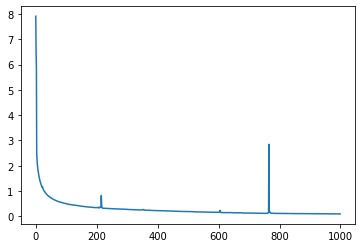

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9819
Test accuracy:  0.9689


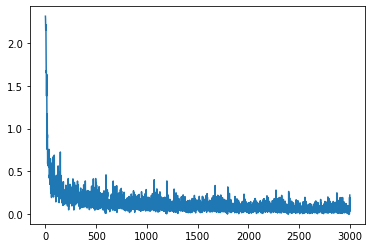

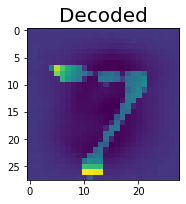

Initializing the network ...
Training the network ...
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9853333333333333  Feed Forward Network
Test accuracy:  0.9668  Feed Forward Network


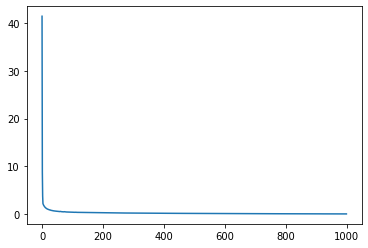

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9872833333333333
Test accuracy:  0.9775


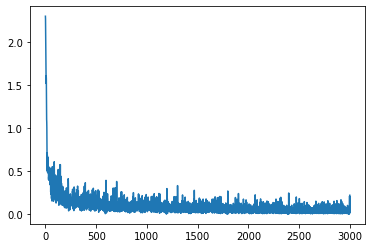

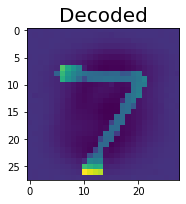

Initializing the network ...
Training the network ...
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9881333333333333  Feed Forward Network
Test accuracy:  0.9655  Feed Forward Network


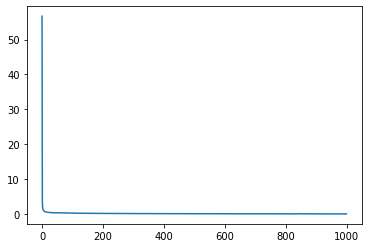

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9874666666666667
Test accuracy:  0.9803


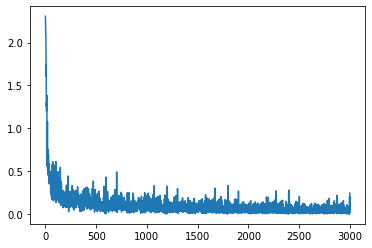

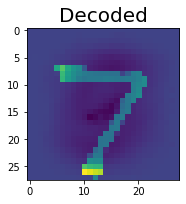

Initializing the network ...
Training the network ...
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9882666666666666  Feed Forward Network
Test accuracy:  0.9654  Feed Forward Network


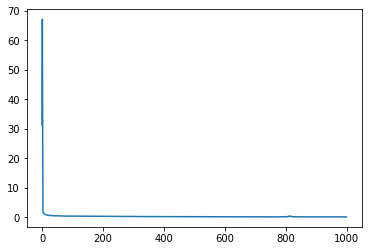

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.98255
Test accuracy:  0.9739


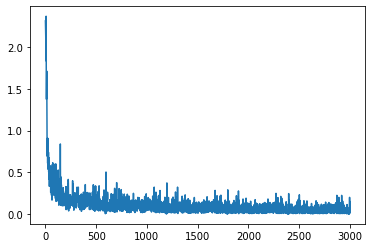

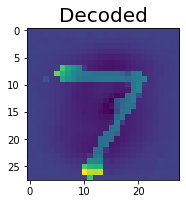

In [70]:
trainLinearAuto(train_data, train_label, test_data, test_label)